In [1]:

import plotly.graph_objs as go
import h5py
import numpy as np
import matplotlib.pyplot as plt 
from SerialReader import SerialReaderPlotter

s = SerialReaderPlotter("COM8", baudrate=9600)

In [2]:
keepAlive = False
    
fig = go.FigureWidget(data=[go.Scatter(x=[], y=[])])
fig.update_layout(
    template="simple_white",
    xaxis_title="Time",
    yaxis_title="Temperature (C)",
)
s.start_reading(500)
s.start_writing(fig)
fig

(Reader   ) Starting
(Plotter  ) Starting


FigureWidget({
    'data': [{'type': 'scatter', 'uid': 'e7666919-78dd-4a8d-a69a-92932fa9f578', 'x': [], 'y': […

(Plotter  ) Waiting for Data


In [10]:
scatter = fig.data[0]

hf = h5py.File('RTA_Run.h5', 'w')
hf.create_dataset('Time', data=np.array(scatter.x, dtype=float))
hf.create_dataset('Temperature', data=np.array(scatter.y, dtype=float))
hf.close()

(Plotter  ) Waiting for Data
(Plotter  ) Waiting for Data
(MainThread) matplotlib data path: C:\Users\labuser\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\mpl-data
(MainThread) CONFIGDIR=C:\Users\labuser\.matplotlib
(MainThread) matplotlib version 3.4.2
(MainThread) interactive is False
(MainThread) platform is win32
(MainThread) loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', '_io', 'marshal', 'nt', 'winreg', '_frozen_importlib_external', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', '_signal', 'encodings.latin_1', '_abc', 'abc', 'io', '__main__', '_stat', 'stat', '_collections_abc', 'genericpath', 'ntpath', 'os.path', 'os', '_sitebuiltins', '_locale', '_bootlocale', 'encodings.cp1252', 'pywin32_system32', 'pywin32_bootstrap', 'types', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib', 'importlib.machinery', '_heapq', 'heapq', 'ite

NameError: name 'np' is not defined

(Plotter  ) Waiting for Data
(MainThread) findfont: Matching Arial:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
(MainThread) findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal 700 normal>) = 11.335
(MainThread) findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
(MainThread) findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'DejaVu Serif Display' (Dej

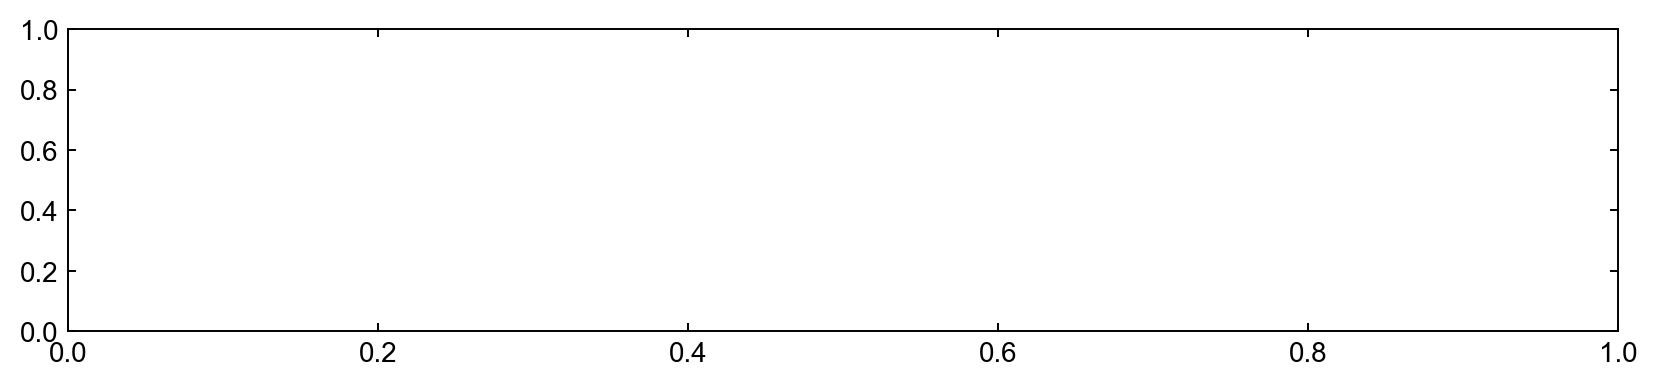

In [3]:
with plt.style.context(["sp-paper"]):
    fig, ax = plt.subplots(figsize=(10,2))
    ax.plot(np.array(scatter.x, dtype=float), np.array(scatter.y, dtype=float))
    ax.autoscale(tight=True)
    ax.margin(y=0.1)